# Assignment 6: Appearance-based gaze estimation - Task 02

Author: `Yintao, Xu` | Date: `2020-02-13 ~ 2020-02-15` | Email: xuyt@shanghaitech.edu.cn

Topics: `numpy`

**Note**: Make sure you have completed `task 01 - pandas notebook`, or you will find this notebook is a little bit challenging!

In this section, we will build a gaze estimation system by KNN(K-nearest neighbour).

![](figures/gaze_model_pipeline.png)


In [2]:
# IMPORTANT: run this cell before runnng any cell to activate auto re-import
%load_ext autoreload
%autoreload 2

# 'gazelib' is the toolkit provided by this assignment, at the same directory of this notebook
from gazelib.utils import *
import numpy as np
import time
import matplotlib.pyplot as plt
import random

In [3]:
# Datasets has been supposed to be downloaded at last notebook
# You could run thie cell to have a check :)
download_csv_mpIIdataset()

[GazeLib] Train csv has downloaded and passed md5 cheking.
[GazeLib] Test csv has downloaded and passed md5 cheking.


In [4]:
# load the training dataset
train_df = load_train_csv_as_df()
train_df.head(10)

,subject_id,yaw,pitch,image_base64
0,5,-0.202976,-0.300898,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
1,5,0.153875,-0.216009,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
2,6,-0.240222,-0.231348,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
3,6,0.082681,-0.148303,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
4,11,0.141780,-0.259967,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
5,14,0.089140,-0.223431,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
6,6,-0.052793,-0.056385,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
7,13,-0.275569,-0.115087,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
8,5,0.095293,-0.210037,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
9,2,-0.066253,-0.250547,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...


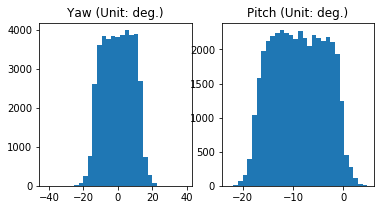

In [5]:
# visualize the distribution of the yaw and pitch
vis.vis_yaw_pitch(train_df)

Before moving on, first, split our dataset(`np_imgs`, `np_gaze_dirs`) into `training set` and `validation set`.

- `Training Dataset`: The sample of data used to generate the model or provide knowledge base for model.
- `Validation Dataset`: The sample of data used to provide an unbiased evaluation of a model fit on the training dataset at our design process. We could test performance of model on this set.
- `Test Dataset`: Other people will judge the performance of your model at their test dataset. The sample of data used to provide an unbiased evaluation of a final model fit on the training dataset.


![](figures/train_val_test.png)

In [6]:
# transform data into numpy arrays
def df2nptensor(df):
    imgs = []
    imgs_HOG = []
    gaze_dirs = []

    print_interval = 1000
    print_cnter = 0
    
    for _, i in df.iterrows():
        if print_cnter % print_interval == 0:
            print("[{} / {}]".format(print_cnter, len(df)), end='\r')
        print_cnter += 1
        im_arr = decode_base64_img(i['image_base64'])
        gaze_dirs.append([i['yaw'], i['pitch']])
        im = im_arr / 255
        
        imgs.append(im)
    
    gaze_dirs = np.array(gaze_dirs)
    imgs = np.array(imgs)
    
    return gaze_dirs, imgs

# For effciency, we only takes first 5,000 samples. Pick subject 5 as validation 
# set and the rest of the dataset as training set
SAMPLE_NUM = 5000
print("Start to generate sampled dataset, it may take ~10s.")
train_Y, train_X = df2nptensor(train_df[train_df["subject_id"] != 5][: int(SAMPLE_NUM * 0.8)])
val_Y, val_X = df2nptensor(train_df[train_df["subject_id"] == 5][: int(SAMPLE_NUM * 0.2)])

print("train_X.shape: {}".format(train_X.shape))
print("train_Y.shape: {}".format(train_Y.shape))
print("val_X.shape: {}".format(val_X.shape))
print("val_Y.shape: {}".format(val_Y.shape))

Start to generate sampled dataset, it may take ~10s.
train_X.shape: (4000, 18, 30)
train_Y.shape: (4000, 2)
val_X.shape: (1000, 18, 30)
val_Y.shape: (1000, 2)


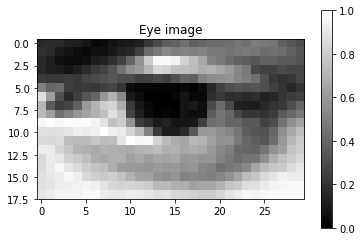

In [7]:
# visulize an image (randomly sampled one, you could repeatedly run this cell)
plt.imshow(train_X[random.randint(0, train_X.shape[0])], vmin=0, vmax=1, cmap="gray")
plt.title("Eye image")
plt.colorbar()
plt.show()

## Section 2.0: Eye Search Engine

In this section, we aim at finding an eye in the database by Euclidean distances between image arrays.

$$
    d = \sqrt{\sum_i \sum_j ( I_{ij}^a - I_{ij}^b )_2}
$$

**Example:** Here is an example of computing Euclidean distance between two images.

You could repeatedly run following cells to see distance between different image pairs.

Euclidean distance: 8.251


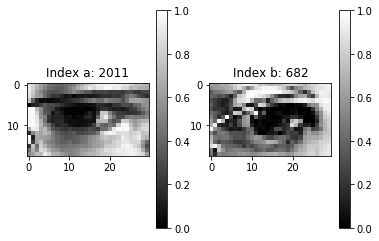

In [8]:
# Example: Compute Euclidean distance of two images
# randomly sample image pair
idx_a, idx_b = random.randint(0, train_X.shape[0]), random.randint(0, train_X.shape[0])
image_a = train_X[idx_a]
image_b = train_X[idx_b]

# compute Euclidean distance by taking norm 2
dist = np.linalg.norm(image_a - image_b)

# visualize
plt.subplot(121)
plt.imshow(image_a, vmin=0, vmax=1, cmap="gray")
plt.colorbar()
plt.title("Index a: {}".format(idx_a))
plt.subplot(122)
plt.imshow(image_b, vmin=0, vmax=1, cmap="gray")
plt.colorbar()
plt.title("Index b: {}".format(idx_b))

print("Euclidean distance: {:.3f}".format(dist))

### Section 2.0.2: K-top Eye Search Engine (10%)

In this section, you are required to implement a simple eye search engine. It is defined as follows: for each sample in validation set, find k samples in training set with most simlarity(sorted from the highest simlarity to the lowest). The simlarity is evalauted by Euclidean distance as mentioned above. 

**Algorithm**:
- Compute Euclidean distance(norm-2) from the `val_x` to each element in `train_X`.
- Sort by Euclidean distances.
- Return the first k indices of elements ascendingly.

You could start from more intuitive 2D cases, then generalize your algorithm to the cases of images. 

Plus, for arrays, each sample is indexed by the first dimension. For example, in 2D cases, each row in a matrix is a sample point.

**Example**:

- train_X = [[0, 0], [1, 1], [2.5, 2.5], [3.5, 3.5]]
- val_x = [2, 2]
- KNN_idx(train_X, val_x, 4) -> [2, 1, 3, 0]

![](figures/code_time.png)
**Complete code at `AppearanceGazeEst.py/KNN_idxs`(10%)**

**Hint**: `np.argsort`

In [9]:
# Local Test 1 - Toy data
# Note: feel free to print out your result to debug if it cannot pass assert_eq_np
from AppearanceGazeEst import KNN_idxs
from gazelib.task_2_judge import assert_eq_np

sanity_trainX =  np.array([[0, 0], [1, 1], [2.5, 2.5], [3.5, 3.5]])
sanity_valX=  np.array([2, 2])

ret = KNN_idxs(sanity_trainX, sanity_valX, 100)
print(ret)
assert_eq_np(ret, np.array([2, 1, 3, 0]))
print("Pass local test 1@2.0.2 - toy data")

[2 1 3 0]
Pass local test 1@2.0.2 - toy data


[3453  604 1817 3645]
Pass local test 2@2.0.2 - eye images


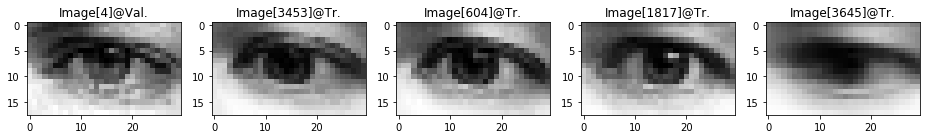

In [10]:
# Local Test 2 - Eye images
# Note: feel free to print out your result to debug if it cannot pass assert_eq_np
from AppearanceGazeEst import KNN_idxs
from gazelib.task_2_judge import assert_eq_np

# pick the second image at validation set and find four images at training set with most simlarity
idx = 10
# print(val_X[idx])
ret = KNN_idxs(train_X, val_X[idx], 4)
print(ret)
assert_eq_np(ret, np.array([3453,  604, 1817, 3645]))
print("Pass local test 2@2.0.2 - eye images")

plt.figure(figsize=(16, 4))
plt.subplot(151)
plt.imshow(val_X[idx] , vmin=0, vmax=1, cmap="gray")
plt.title("Image[4]@Val.")

for i in range(4):
    plt.subplot(152 + i)
    plt.imshow(train_X[ret[i]] , vmin=0, vmax=1, cmap="gray")
    plt.title("Image[{}]@Tr.".format(ret[i]))

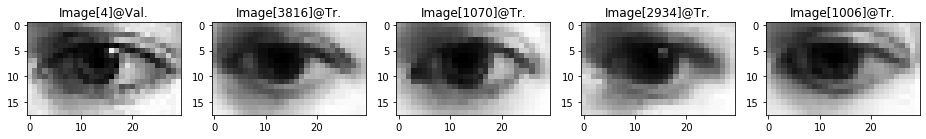

In [11]:
# Playground
from AppearanceGazeEst import KNN_idxs
from gazelib.task_2_judge import assert_eq_np

rdn_idx = random.randint(0, val_X.shape[0])
ret = KNN_idxs(train_X, val_X[rdn_idx], 4)


plt.figure(figsize=(16, 4))
plt.subplot(151)
plt.imshow(val_X[rdn_idx] , vmin=0, vmax=1, cmap="gray")
plt.title("Image[4]@Val.")

for i in range(4):
    plt.subplot(152 + i)
    plt.imshow(train_X[ret[i]] , vmin=0, vmax=1, cmap="gray")
    plt.title("Image[{}]@Tr.".format(ret[i]))

## Section 2.1: From Search Engine To A Baseline Estimator - 1-NN estimator (5%)

At previous sections, we built a search engine of eye images. In fact, by simply injecting lines of code at previous process, the "search engine" could be converted into a gaze estimator.

![](figures/1_NN_new.png)

- Compute the Euclidean distance from the query example(`val_x`) to the labeled examples.
- Find the image with the most simlarity(one image in `train_X` with the nearest Euclidean distance).
- Take its corresponding label as output(`train_Y[min_idx]`).

You could start from more intuitive 2D case, then generalize your algorithm to the case of images. Intuitively, it takes the label of the nearest sample as output. Therefore, it is called "one nearest neighbour".

**Example(2D Case)**:
- `train_X` = [[0, 0], [1, 1], [2.5, 2.5], [3.5, 3.5]]
- `train_Y` = [[20], [30], [40], [50]]
- `val_x` = [2, 2]
- `KNN_idx(train_X, val_x, 1)` -> [2]
- `oneNN(train_X, train_Y, val_x)` -> `train_Y[2]` <-> [40]

![](figures/code_time.png)
**Complete code at `AppearanceGazeEst.py/oneNN`(5%)**

In [12]:
# Local Test 1 - Toy data
# Note: feel free to print out your result to debug if it cannot pass assert_eq_np
from AppearanceGazeEst import oneNN
from gazelib.task_2_judge import assert_eq_np

sanity_trainX = np.array([[0, 0], [1, 1], [2.5, 2.5], [3.5, 3.5]])
sanity_trainY = np.array([[20], [30], [40], [50]])
sanity_valX=  np.array([2, 2])

ret = oneNN(sanity_trainX, sanity_trainY, sanity_valX)

print(ret)

assert_eq_np(ret, 40)
print("Pass local test 1@2.1 - toy data")

[40]
Pass local test 1@2.1 - toy data


[ 0.1283756  -0.09948426]
[ 0.1283756  -0.09948426]
Pass local test 2@2.1 - eye images


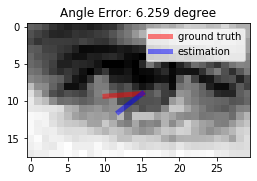

In [13]:
# Local Test 2 - Eye images
# Note: feel free to print out your result to debug if it cannot pass assert_eq_np
from AppearanceGazeEst import oneNN
from gazelib.task_2_judge import assert_eq_np
from gazelib.task_3_judge import compute_angle_error

idx = 10
ret = oneNN(train_X, train_Y, val_X[idx])
assert_eq_np(ret, np.array([ 0.1283756,  -0.09948426]))
print(ret)
print(np.array([ 0.1283756,  -0.09948426]))
print("Pass local test 2@2.1 - eye images")
plt.figure(figsize=(4, 3))
vis.visualize_est(val_X[idx], ret, val_Y[idx])
plt.title("Angle Error: {:.3f} degree".format(compute_angle_error(val_Y[idx], ret)));

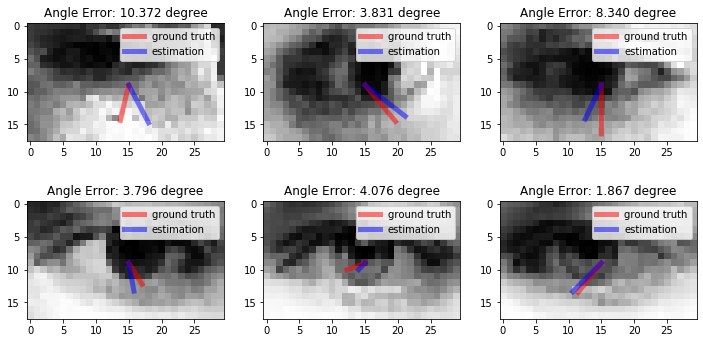

In [14]:
# Playground
from AppearanceGazeEst import oneNN
from gazelib.task_2_judge import assert_eq_np

plt.figure(figsize=(12, 6))
for i in range(6):
    plt.subplot(231 + i)
    random_idx = random.randint(0, val_X.shape[0])
    ret = oneNN(train_X, train_Y, val_X[random_idx])

    vis.visualize_est(val_X[random_idx], ret, val_Y[random_idx])
    plt.title("Angle Error: {:.3f} degree".format(compute_angle_error(val_Y[random_idx], ret)));

## Section 2.2: From  1-NN estimator to K-NN estimator (5%)

For the 1-NN estimation of gaze, the most simlar eye is found and its gaze information is copied as output. It is also intuitive to rely on multiple samples at training set and output an average of them as the final result. Here comes the K-NN.

- Compute the Euclidean distance from the query example(`val_x`) to the labeled examples.
- Find the k images with the most simlarity(k imags in `train_X` with the nearest Euclidean distance).
- Take the median of their corresponding labels as output.

You could start from more intuitive 2D case, then generalize your algorithm to the case of images.

**Example(2D Case)**:
- `train_X` = [[0, 0], [1, 1], [2.5, 2.5], [3.5, 3.5]]
- `train_Y` = [[20], [30], [40], [50]]
- `val_x` = [2, 2]
- `KNN_idx(train_X, val_x, 2)` -> [2, 1]
- `KNN(train_X, train_Y, val_x, 2)` -> `np.median(train_Y[[2, 1])` <-> (40 + 30) / 2 <-> 35

![](figures/code_time.png)
**Complete code at `AppearanceGazeEst.py/KNN`(5%)**

In [15]:
# Local Test 1 - Toy data
# Note: feel free to print out your result to debug if it cannot pass assert_eq_np
from AppearanceGazeEst import KNN
from gazelib.task_2_judge import assert_eq_np

sanity_trainX = np.array([[0, 0], [1, 1], [2.5, 2.5], [3.5, 3.5]])
sanity_trainY = np.array([[20], [30], [40], [50]])
sanity_valX=  np.array([2, 2])

ret = KNN(sanity_trainX, sanity_trainY, sanity_valX, 2)
assert_eq_np(ret, 35)
print("Pass local test 1@2.2 - toy data")

IndexError: index 1 is out of bounds for axis 0 with size 1

[ 0.04550109 -0.05406717]
Pass local test 2@2.2 - eye images


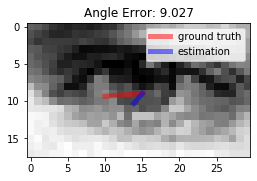

In [16]:
# Local Test 2 - Eye images
# Note: feel free to print out your result to debug if it cannot pass assert_eq_np
from AppearanceGazeEst import KNN
from gazelib.task_2_judge import assert_eq_np
from gazelib.task_3_judge import compute_angle_error

idx = 10
ret = KNN(train_X, train_Y, val_X[idx], 10)
print(ret)

assert_eq_np(ret, np.array([ 0.04550109, -0.05406717]))

print("Pass local test 2@2.2 - eye images")
plt.figure(figsize=(4, 3))
vis.visualize_est(val_X[idx], ret, val_Y[idx])
plt.title("Angle Error: {:.3f}".format(compute_angle_error(val_Y[idx], ret)));

[ 0.09439091 -0.09992683]
[-0.06385783 -0.10244152]
[ 0.05104985 -0.25026628]
[ 0.1615911  -0.23068374]
[ 0.09474498 -0.17406061]
[-0.10216326 -0.17880451]


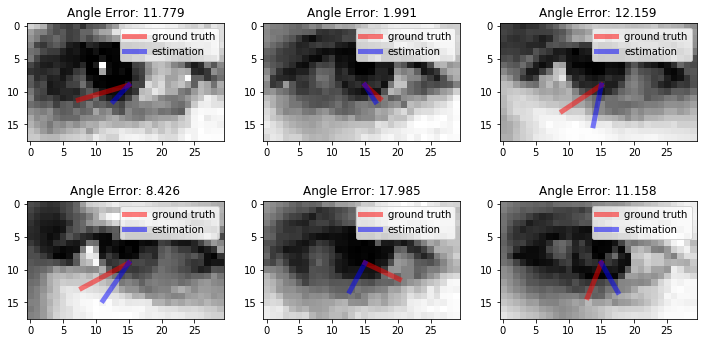

In [25]:
# Playground
from AppearanceGazeEst import KNN
from gazelib.task_2_judge import assert_eq_np

plt.figure(figsize=(12, 6))
for i in range(6):
    plt.subplot(231 + i)
    random_idx = random.randint(0, val_X.shape[0])
    ret = KNN(train_X, train_Y, val_X[random_idx], k=10)
    print(ret)

    vis.visualize_est(val_X[random_idx], ret, val_Y[random_idx])
    plt.title("Angle Error: {:.3f}".format(compute_angle_error(val_Y[random_idx], ret)));

# Section 2.3: K-NN Estimator With Weighted Average(15%)

Naively take median of labels neglect the distance between the input and k-top instances at database. A weighted average sounds more robust.

**Intuition**: Further the distance is, weaker the correlation between those two samples is.  

- Compute the Euclidean distance from the query example(`val_x`) to the labeled examples.
- Find the k images with the most simlarity(k images in `train_X` with the nearest Euclidean distance).
- Denote the multiplicative inverse of distances as a score vector:

$$
    \textbf{s} = [1 / d_1, 1 / d_2, \cdots, 1 / d_k]
$$

- Denote their corresponding labels(gaze direction, a 2-d vector in this context).

$$
    \textbf{y} = [\textbf{y}_1, \textbf{y}_2, \cdots, \textbf{y}_k]
$$

- Normalize the vector by the sum of distance.


$$
    \textbf{s}_{norm} = [s_1 / \sum_i^k s_i, s_2 / \sum_i^k s_i, \cdots, s_k / \sum_i^k s_i]
$$

- Return the weighted sum.

$$
    \textbf{o} = \sum_{i}^{k} \textbf{s}_{norm, i} * \textbf{y}_{i}
$$

You could start from more intuitive 2D case, then generalize your algorithm to the case of images.

**Example(2D Case)**:
- `train_X` = [[0, 0], [1, 0], [3, 0], [4, 0]]
- `train_Y` = [[20], [30], [40], [50]]
- `val_x` = [2, 0]
- `s` = [1/1, 1/1] = [1, 1]
- `s_norm` = [0.5, 0.5]
- `KNN_weighted(train_X, train_Y, val_x, 2)` -> `0.5 * 30 + 0.5 * 40` <-> 35

![](figures/code_time.png)
**Complete code at `AppearanceGazeEst.py/KNN_weighted`(15%)**

In [ ]:
# Local Test 1 - Toy data
# Note: feel free to print out your result to debug if it cannot pass assert_eq_np
from AppearanceGazeEst import KNN_weighted
from gazelib.task_2_judge import assert_eq_np

sanity_trainX = np.array([[0, 0], [1, 0], [3, 0], [4, 0]])
sanity_trainY = np.array([[20], [30], [40], [50]])
sanity_valX=  np.array([2, 0])

ret = KNN_weighted(sanity_trainX, sanity_trainY, sanity_valX, 2)
print(ret)
assert_eq_np(ret, 35)
print("Pass local test 1@2.3 - toy data")

In [ ]:
# Local Test 2 - Eye images
# Note: feel free to print out your result to debug if it cannot pass assert_eq_np
from AppearanceGazeEst import KNN_weighted
from gazelib.task_2_judge import assert_eq_np
from gazelib.task_3_judge import compute_angle_error

idx = 10
ret = KNN_weighted(train_X, train_Y, val_X[idx], 5)
print(ret)
assert_eq_np(ret, np.array([0.08485499, -0.0870907 ]))

print("Pass local test 2@2.3 - eye images")
plt.figure(figsize=(4, 3))
vis.visualize_est(val_X[idx], ret, val_Y[idx])
plt.title("Angle Error: {:.3f}".format(compute_angle_error(val_Y[idx], ret)));

In [ ]:
# Playground
from AppearanceGazeEst import KNN_weighted
from gazelib.task_2_judge import assert_eq_np

plt.figure(figsize=(12, 6))
for i in range(6):
    plt.subplot(231 + i)
    random_idx = random.randint(0, val_X.shape[0])
    ret = KNN_weighted(train_X, train_Y, val_X[random_idx], k=10)

    vis.visualize_est(val_X[random_idx], ret, val_Y[random_idx])
    plt.title("Angle Error: {:.3f}".format(compute_angle_error(val_Y[random_idx], ret)));

## Section 2.3: Demo - Playground (0%)
Visualize the gaze over an image directly

In [ ]:
from gazelib.utils import download_demo_Img, load_demo_Img

download_demo_Img()
# You can have your own image at assignment_Gaze/dataset(comment download commend above), 
# the load_deomo_Img() will return first noncsv as an image back, with the support of most
# formats of image
demo_im = load_demo_Img()

plt.imshow(demo_im)
plt.show()

In [ ]:
from gazelib.demo import estimate_gaze
from gazelib.task_3_judge import convert_to_unit_vector
import numpy as np

def eyeim2gaze(eye_im):
    y_est = KNN(train_X, train_Y, eye_im, k=5)
    
    return convert_to_unit_vector(y_est)


estimate_gaze(demo_im, eyeim2gaze)

![](figures/good_job_banner.png)
You should have completed **all cells(35%)** in this task locally when you reach here! You are able to build a data-driven gaze estimator.

**CheckList**

- KNN_idxs (10%)
- oneNN (5%)
- KNN (5%)
- KNN_weighted (15%)